In [1]:
!pip install pandas
!pip install matplotlib

In [129]:
# Import the packages we will use
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py
import random
import cooler

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# The following directive activates inline plotting
%matplotlib inline

## Подгружаем матрицу в нужном разрешении

cooler использует символы ```::``` для доступа к датасетам внутри hdf5 контейнера.

Загрузим все датасеты с разрешения 50000

In [59]:
cool = cooler.Cooler('data/mopti_female_scaffolded_4DN.mcool::/resolutions/50000')

Визуализируем матрицу контактов

In [65]:
arr = c.matrix(balance=False, sparse=False)[:,:]
arr

array([[ 570,  635,   95, ...,    2,    2,    0],
       [ 635, 7670, 3467, ...,    3,    1,    0],
       [  95, 3467, 6554, ...,    0,    0,    0],
       ...,
       [   2,    3,    0, ..., 2455,   19,    0],
       [   2,    1,    0, ...,   19, 1293,    0],
       [   0,    0,    0, ...,    0,    0,    7]], dtype=int32)

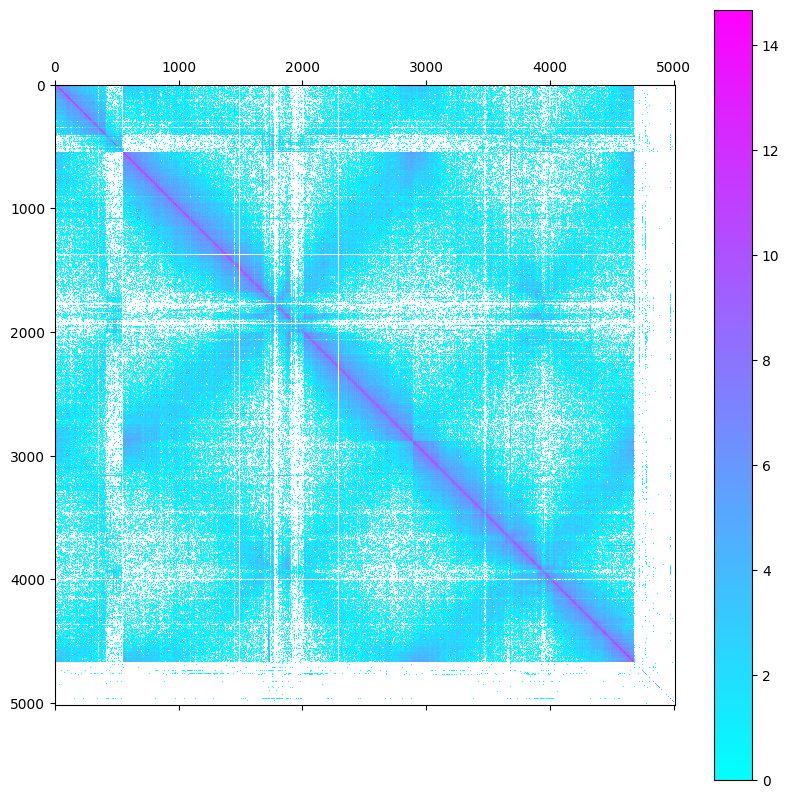

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log2(arr), cmap='cool')
fig.colorbar(im)
None

## Хромосомы
Узнаем длину и соответственно границы хромосом в бинах

сперва посмотрим на длину в нуклеотидах

У комара 3 хромосомы: X, 2, 3

В данной сборке аутосомы разделены по плечам на R и L скаффолды

In [95]:
chroms = cool.chroms()[:5]
chroms

,name,length
0,X,27411291
1,2R,61152830
2,2L,55695877
3,3R,50025520
4,3L,39144225


Длина в бинах будет равнятся длине в нуклеотидах поделить на разрешение + 1

In [96]:
chroms.length = chroms.length // 50000 + 1
chroms

,name,length
0,X,549
1,2R,1224
2,2L,1114
3,3R,1001
4,3L,783


Отрисуем границы хромосом на карте контактов

In [117]:
line_coords = reduce(lambda x, y: x + [x[-1] + y], chroms.length, [0])[1:]
line_coords

[549, 1773, 2887, 3888, 4671]

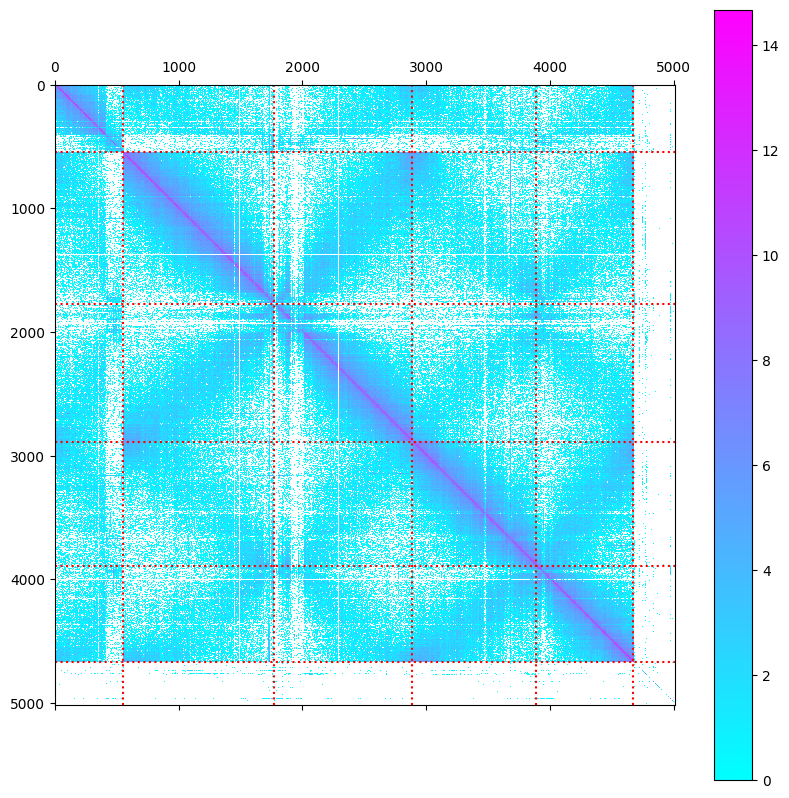

In [125]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log2(arr), cmap='cool')
for coord in line_coords:
    plt.axhline(coord, color='r', linestyle=':')
    plt.axvline(coord, color='r', linestyle=':')
fig.colorbar(im)
None

## Инвариант I
## Intrachromosomal interaction enrichment

![](img/inv1.jpg)

![](img/inv1.png)

Первый инвариант показывает, что внутрихромосомные интеракции в среднем всегда больше, чем межхромосомные.

Посчитаем и визуализируем полученные метрики, взяв для каждой координаты i на хромосоме 1000 случайных пар координат j и k, таких что j лежит на этой же хромосоме, k находится на люьой другой хромосоме.

In [164]:
chroms

,name,length
0,X,549
1,2R,1224
2,2L,1114
3,3R,1001
4,3L,783


In [165]:
line_coords

[549, 1773, 2887, 3888, 4671]

In [172]:
chrom_borders = (0,549,2887,4671)

In [173]:
consistent = []
inconsistent = []

In [176]:
def count_invariant_I(arr, i, intra_coords, inter_coords):
    satisfied = 0
    for _ in range(1000):
        j = random.randint(*intra_coords)
        k = random.choice(inter_coords)
        if arr[i,j] > arr[i,k]:
            satisfied += 1
    return satisfied / 1000

In [177]:
for chrom in range(3):
    intra_coords = (chrom_borders[chrom], chrom_borders[chrom + 1])
    inter_coords = list(range(0, chrom_borders[chrom])) +\
                   list(range(chrom_borders[chrom + 1], 4671))
    for i in range(*intra_coords):
        inv = count_invariant_I(arr, i, intra_coords, inter_coords)
        consistent.append(inv)
        inconsistent.append(1 - inv)

Визуализируем, полученные метрики

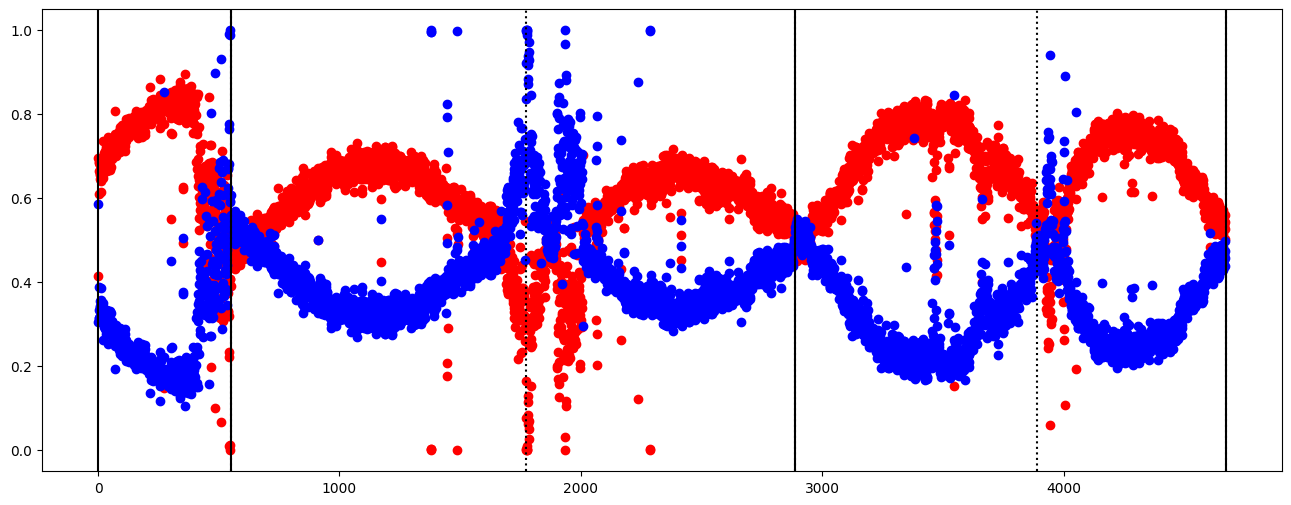

In [186]:
x = list(range(0,4671))
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
ax.scatter(x, consistent, color='r')
ax.scatter(x, inconsistent, color='b')
for coord in chrom_borders:
    plt.axvline(coord, color='black', linestyle='-')
for coord in line_coords:
    plt.axvline(coord, color='black', linestyle=':')
None

Как мы можем видеть в маленьком ядре малярийного комара первый инвариант выполняется не строго. Очень сильно межхромосомное взаимодействие, особенно в перицентромерных и теломерных регионах. Именно это мы и наблюдаем на карте контактов в виде побочных диагоналей и усиленного сигнала на пересечении центромерных регионов.

![](img/map.jpg)